# FINAL PROJECT: Regression and neural networks

In [4]:
import io
import requests
import logging
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_squared_error, r2_score,
                             confusion_matrix, ConfusionMatrixDisplay)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Make notebook output stable across runs
random_state = 100
np.random.seed(random_state)

# Options for plots
%matplotlib inline
sns.set()
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 12

## Regression

In [5]:
df = pd.read_csv('./flights_sample_3m_cleaned.csv')

In [6]:
df.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6
0,715,186.0,1065.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1280,235.0,1399.0,0.0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,594,118.0,680.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,969,260.0,1589.0,0.0,24.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1120,181.0,985.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [7]:
# Cancelled flight show as no delay and no delay time. But they are still a failure
# For our delay time model, we will only attempt non cancelled flight, since
# cancelled flights likely have similar predictors, and so classifying them as 0 delay
# will throw the model off

# Could also be reasonable to set a value for delay time for the cancelled flights,
# however I think there would need to be more expertise to decide what a good value should be there

# Instead, if we try to classify flights, then this model can be used to predict delay times
# for flights that are not classified as cancelled prediction

df_delayed = df[df['CANCELLED'] == 0]

In [8]:
df_delayed.drop('CANCELLED', axis=1, inplace=True)

/var/folders/42/lwn0p9jn7tx0bxw3zzznklvr0000gn/T/ipykernel_8245/1952734233.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delayed.drop('CANCELLED', axis=1, inplace=True)


In [42]:
# Create random subset for quicker testing and debugging of code
#df_subset = df.sample(500000)

In [13]:
feature_vars = list(df_delayed.columns)

In [14]:
#feature_vars.remove('CANCELLED')
#feature_vars.remove('DELAYED')
feature_vars.remove('DELAYED_TIME')

Neural Networks Attempt

In [16]:
# Time for the model
X = df_delayed[feature_vars]
y = df_delayed['DELAYED_TIME']

# Split data into training and testing sets
(X_train_full, X_test, 
 y_train_full, y_test) = train_test_split(X, y, test_size=0.2,
                                          stratify=df_delayed['DELAYED'],
                                          random_state=random_state)

# Split training data into training and validation subsets
(X_train, X_valid, 
 y_train, y_valid) = train_test_split(X_train_full, y_train_full,
                                      test_size=0.2,
                                      stratify=X_train_full['DELAYED'],
                                      random_state=random_state)


In [17]:
# Drop the DELAYED column now that we stratified
X_train_full = X_train_full.drop('DELAYED', axis=1)
X_train = X_train.drop('DELAYED', axis=1)
X_valid = X_valid.drop('DELAYED', axis=1)
X_test = X_test.drop('DELAYED', axis=1)

In [18]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [19]:
X_train.shape[1:]

(187,)

In [23]:
# Create model
tf.keras.backend.clear_session()
# Note we always have to clear session so it knows we are starting over rather than fine tuning

model = keras.models.Sequential([
    keras.layers.Dense(
        5, activation='relu',
        input_shape=X_train.shape[1:]
    ),
    keras.layers.Dense(1)
])
# Created new dense layer with 10 neurons and relu activation function 
# sketch of the model below
# input layer: 187 neurons (one for each feature)
# hidden layer: 10 neurons
# output layer: 1 neuron

# Adam is an algorithm based on adaptive moment estimation
# See HOML Chapter 11 for details
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=opt)

# Saving a model
model.save('mlp_delay_v1.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 940       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 946
Trainable params: 946
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Evaluate on test data

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

313/313 [==============================] - 1s 1ms/step
RMSE: 22.847
R2:   0.697



So our first model performance, 250 epochs and like 3 neurons?:
RMSE: 4.682
R2:   0.987

2nd Model, utilizing 500 epochs and 10 neurons
RMSE: 22.847
R2:   0.697

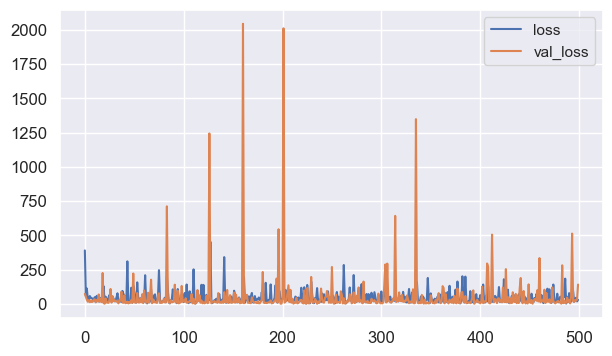

In [77]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(7, 4))
plt.grid(True)
plt.show()

Val_loss sometimes spikes, seems like first smaller spike is around 80 or 90 with then bigger and more spikes after 100. I will limit model to 70 epochs to test performance

In [24]:
# Create model
tf.keras.backend.clear_session()
# Note we always have to clear session so it knows we are starting over rather than fine tuning

model = keras.models.Sequential([
    keras.layers.Dense(
        5, activation='relu',
        input_shape=X_train.shape[1:]
    ),
    keras.layers.Dense(1)
])
# Created new dense layer with 5 neurons and relu activation function 
# sketch of the model below
# input layer: 238 neurons (one for each feature)
# hidden layer: 5 neurons
# output layer: 1 neuron

# Adam is an algorithm based on adaptive moment estimation
# See HOML Chapter 11 for details
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=opt)

# Saving a model
model.save('mlp_delay_time_v1.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 940       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 946
Trainable params: 946
Non-trainable params: 0
_________________________________________________________________


In [25]:
tf.keras.backend.clear_session()

In [26]:
# Loading a model
model = keras.models.load_model('mlp_delay_time_v1.h5')

# Using callbacks to fit a model while saving the
# best performer on the validation data
checkpoint_cb = keras.callbacks.ModelCheckpoint('mlp_delay_time_best.h5',
                                                save_best_only=True)

history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb],
                    verbose=1)

model = keras.models.load_model('mlp_delay_time_best.h5')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

Epoch 1/200
42218/42218 [==============================] - 106s 2ms/step - loss: 2156.6399 - val_loss: 2022.3015
Epoch 2/200
42218/42218 [==============================] - 94s 2ms/step - loss: 2161.2065 - val_loss: 2030.7281
Epoch 3/200
42218/42218 [==============================] - 95s 2ms/step - loss: 2164.6218 - val_loss: 2031.7819
Epoch 4/200
42218/42218 [==============================] - 78s 2ms/step - loss: 2166.0815 - val_loss: 2035.0651
Epoch 5/200
42218/42218 [==============================] - 80s 2ms/step - loss: 2168.6560 - val_loss: 2033.6249
Epoch 6/200
42218/42218 [==============================] - 82s 2ms/step - loss: 2169.8938 - val_loss: 2198.7441
Epoch 7/200
42218/42218 [==============================] - 111s 3ms/step - loss: 2178.9807 - val_loss: 2030.1157
Epoch 8/200
42218/42218 [==============================] - 103s 2ms/step - loss: 2168.1797 - val_loss: 2046.0859
Epoch 9/200
42218/42218 [==============================] - 93s 2ms/step - loss: 2181.7668 - val_loss:

input layer: 238 neurons (one for each feature)
hidden layer: 5 neurons
output layer: 1 neuron
200 epochs
save best only
5.5 hours

RMSE: 45.653
R2:   0.004

In [28]:
y_pred.min()

-3.2572174

In [27]:
y_pred.max()

87.46568

In [29]:
y_pred

array([[12.579819],
       [12.579819],
       [12.579819],
       ...,
       [12.579819],
       [12.579819],
       [12.579819]], dtype=float32)

In [32]:
np.count_nonzero(y_pred <= 20)
# get count from y_pred for value


413100

In [33]:
np.count_nonzero(y_pred > 20)

9074

In [37]:
df_mlp_v1 = df.loc[y_test.index]

In [39]:
df_mlp_v1['PRED_DELAY_TIME'] = y_pred
df_mlp_v1.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,PRED_DELAY_TIME
1947749,665,90.0,417.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,12.579819
1824884,1345,105.0,580.0,0.0,68.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,12.579819
1823280,734,103.0,507.0,0.0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,12.579819
554871,640,158.0,860.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,12.579819
473879,1402,315.0,2429.0,0.0,0.0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,12.579819


In [200]:
df_mlp_v1['PRED_DELAY_TIME']

1947749    10.856287
1824884    10.856287
1823280    10.856287
554871     10.856287
473879     10.856287
             ...    
1662884    10.856287
342754     10.856287
1950836    10.856287
727994     10.856287
1982802    10.856287
Name: PRED_DELAY_TIME, Length: 422174, dtype: float32

In [197]:
df_mlp_v1[(df_mlp_v1['PRED_DELAY_TIME'] > 13) & (df_mlp_v1['DELAYED'] == 1)].shape[0] / df_mlp_v1[df_mlp_v1['PRED_DELAY_TIME'] > 13].shape[0]

ZeroDivisionError: division by zero

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import PredictionErrorDisplay

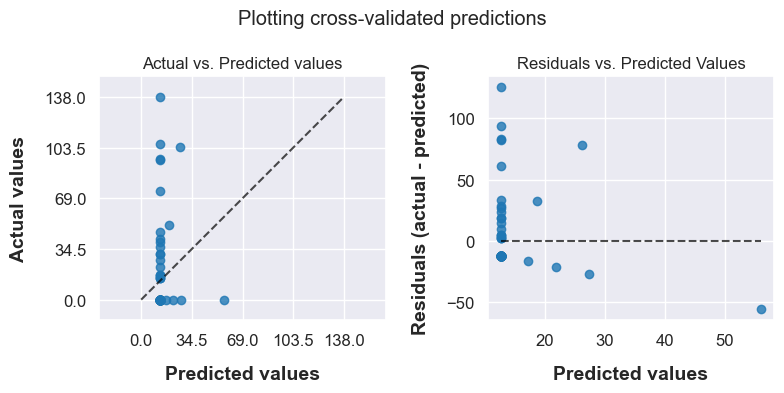

In [42]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    df_mlp_v1['DELAYED_TIME'],
    y_pred=df_mlp_v1['PRED_DELAY_TIME'],
    kind="actual_vs_predicted",
    subsample=100,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    df_mlp_v1['DELAYED_TIME'],
    y_pred=df_mlp_v1['PRED_DELAY_TIME'],
    kind="residual_vs_predicted",
    subsample=100,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

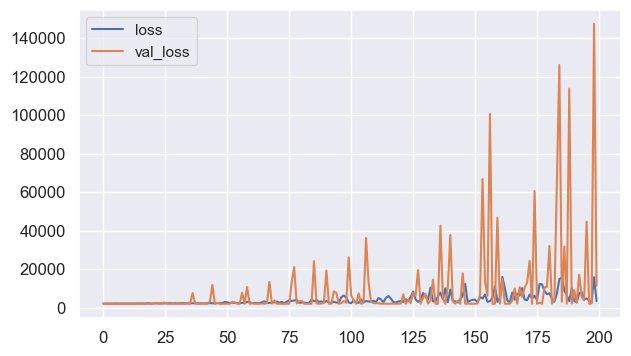

In [43]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(7, 4))
plt.grid(True)
plt.show()

Did too many epochs, started getting val loss spikes after 100

In [52]:
# Create model
tf.keras.backend.clear_session()
# Note we always have to clear session so it knows we are starting over rather than fine tuning

model = keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='relu', input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(15, activation='relu'))
model.add(keras.layers.Dense(1))
# Created new dense layer with 25 neurons and relu activation function 
# sketch of the model below
# input layer: 237 neurons (one for each feature)
# hidden layer: 50 neurons
# hidden layer: 15 neurons
# output layer: 1 neuron

# Adam is an algorithm based on adaptive moment estimation
# See HOML Chapter 11 for details
opt = keras.optimizers.Adam(learning_rate=0.2)
model.compile(loss='mse', optimizer=opt)

# Saving a model
model.save('mlp_delay_v2.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                9400      
                                                                 
 dense_1 (Dense)             (None, 15)                765       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 10,181
Trainable params: 10,181
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Using an early-stopping callback to stop after 10 epochs with no improvement
model = keras.models.load_model('mlp_delay_v2.h5')

history = model.fit(X_train, y_train, epochs=150,
                    validation_data=(X_valid, y_valid),
                    callbacks = [keras.callbacks.EarlyStopping(patience=5)],
                    verbose=1)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n') 

Epoch 1/150
42218/42218 [==============================] - 215s 5ms/step - loss: 2164.2920 - val_loss: 2030.4094
Epoch 2/150
42218/42218 [==============================] - 196s 5ms/step - loss: 2163.3567 - val_loss: 2031.1273
Epoch 3/150
42218/42218 [==============================] - 197s 5ms/step - loss: 2163.3318 - val_loss: 2029.6229
Epoch 4/150
42218/42218 [==============================] - 184s 4ms/step - loss: 2163.3450 - val_loss: 2031.5295
Epoch 5/150
42218/42218 [==============================] - 192s 5ms/step - loss: 2163.4216 - val_loss: 2032.3918
Epoch 6/150
42218/42218 [==============================] - 203s 5ms/step - loss: 2163.3445 - val_loss: 2030.5464
Epoch 7/150
42218/42218 [==============================] - 191s 5ms/step - loss: 2163.4153 - val_loss: 2029.5209
Epoch 8/150
42218/42218 [==============================] - 181s 4ms/step - loss: 2163.3372 - val_loss: 2030.2887
Epoch 9/150
42218/42218 [==============================] - 177s 4ms/step - loss: 2163.3953 - val

RMSE: 45.763
R2:   -0.001

input layer: 237 neurons (one for each feature)
hidden layer: 50 neurons
hidden layer: 15 neurons
output layer: 1 neuron

In [57]:
df_mlp_v2 = df.loc[y_test.index]

In [59]:
df_mlp_v2['PRED_DELAY_TIME'] = y_pred
df_mlp_v2.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,PRED_DELAY_TIME
1947749,665,90.0,417.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,10.856287
1824884,1345,105.0,580.0,0.0,68.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,10.856287
1823280,734,103.0,507.0,0.0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,10.856287
554871,640,158.0,860.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,10.856287
473879,1402,315.0,2429.0,0.0,0.0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,10.856287


In [202]:
df_mlp_v2[df_mlp_v2['PRED_DELAY_TIME'] < 10]

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,PRED_DELAY_TIME


In [204]:
df_mlp_v2[df_mlp_v2['PRED_DELAY_TIME'] > 11]

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,PRED_DELAY_TIME


We are getting not great performance trying to predict delay time with majority of flights not being delayed, causing our regression line to not be steep enough and therefore predicts low for actual delays and high for many non delays

The best approach may be to use classification, and then if we have a fairly accurate classification model we feed those into a delay time predictor trained only on delayed flights. This would likely lead to more accuracy with delays, and predicted 0 for ones we do not believe are a delay.

However, this will make flights we classify as a delay, but are not, be fed into this steeper model that will lead to a longer flight delay time prediction for a non-delayed flight. I think it is a worthy trade off, but may need to make our threshold in the classification model stricter for marking a delay prediction for this reason.

In [61]:
# Lets take just the DELAYED flights in df
# and attempt to get better mse / R2
df_del_fl = df[df['DELAYED'] == 1]
df_del_fl.shape

(394332, 190)

In [65]:
feature_vars.remove('DELAYED')

In [66]:
# Time for the model
X = df_del_fl[feature_vars]
y = df_del_fl['DELAYED_TIME']

# Split data into training and testing sets
(X_train_full, X_test, 
 y_train_full, y_test) = train_test_split(X, y, test_size=0.2,
                                          random_state=random_state)

# Split training data into training and validation subsets
(X_train, X_valid, 
 y_train, y_valid) = train_test_split(X_train_full, y_train_full,
                                      test_size=0.2,
                                      random_state=random_state)

In [67]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [68]:
# Create model
tf.keras.backend.clear_session()
# Note we always have to clear session so it knows we are starting over rather than fine tuning

model = keras.models.Sequential()
model = keras.models.Sequential()
model.add(keras.layers.Dense(60, activation='relu', input_shape=X_train.shape[1:]))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(1))
# Created new dense layer with 5 neurons and relu activation function 
# sketch of the model below
# input layer: 238 neurons (one for each feature)
# hidden layer: 60 neurons
# hidden layer: 30 neurons
# output layer: 1 neuron

# Adam is an algorithm based on adaptive moment estimation
# See HOML Chapter 11 for details
opt = keras.optimizers.Adam(learning_rate=0.15)
model.compile(loss='mse', optimizer=opt)

# Saving a model
model.save('mlp_delay_time_v3.h5')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                11280     
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 13,141
Trainable params: 13,141
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Loading a model
model = keras.models.load_model('mlp_delay_time_v3.h5')

# Using callbacks to fit a model while saving the
# best performer on the validation data
checkpoint_cb = keras.callbacks.ModelCheckpoint('mlp_delay_time_v3_best.h5',
                                                save_best_only=True)

history = model.fit(X_train, y_train, epochs=300,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb],
                    verbose=1)

model = keras.models.load_model('mlp_delay_time_v3_best.h5')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

Epoch 1/300
7887/7887 [==============================] - 39s 5ms/step - loss: 8025.4604 - val_loss: 7652.1870
Epoch 2/300
7887/7887 [==============================] - 43s 5ms/step - loss: 7915.2905 - val_loss: 7652.3726
Epoch 3/300
7887/7887 [==============================] - 36s 5ms/step - loss: 7915.5923 - val_loss: 7655.3086
Epoch 4/300
7887/7887 [==============================] - 40s 5ms/step - loss: 7915.4907 - val_loss: 7652.4292
Epoch 5/300
7887/7887 [==============================] - 36s 5ms/step - loss: 7915.2241 - val_loss: 7654.9893
Epoch 6/300
7887/7887 [==============================] - 36s 5ms/step - loss: 7915.2983 - val_loss: 7652.3999
Epoch 7/300
7887/7887 [==============================] - 34s 4ms/step - loss: 7915.4976 - val_loss: 7652.0781
Epoch 8/300
7887/7887 [==============================] - 36s 5ms/step - loss: 7915.5605 - val_loss: 7652.8276
Epoch 9/300
7887/7887 [==============================] - 48s 6ms/step - loss: 7915.7720 - val_loss: 7653.5024
Epoch 10/3

RMSE: 88.397
R2:   -0.000

In [71]:
df_mlp_v3 = df.loc[y_test.index]
df_mlp_v3['PRED_DELAY_TIME'] = y_pred

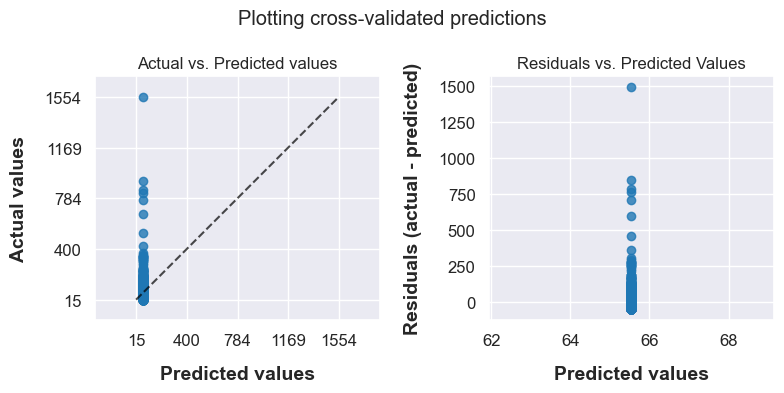

In [72]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    df_mlp_v3['DELAYED_TIME'],
    y_pred=df_mlp_v3['PRED_DELAY_TIME'],
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    df_mlp_v3['DELAYED_TIME'],
    y_pred=df_mlp_v3['PRED_DELAY_TIME'],
    kind="residual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

In [75]:
# Create model
tf.keras.backend.clear_session()
# Note we always have to clear session so it knows we are starting over rather than fine tuning

model = keras.models.Sequential([
    keras.layers.Dense(
        100, activation='relu',
        input_shape=X_train.shape[1:]
    ),
    keras.layers.Dense(
        50, activation='relu',
        input_shape='100'
    ),
    keras.layers.Dense(
        10, activation='relu',
        input_shape='50'
    ),
    keras.layers.Dense(1)
])

opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=opt)

# Saving a model
model.save('mlp_delay_v4.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               18800     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 24,371
Trainable params: 24,371
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(X_train, y_train, epochs=200,
                    validation_data=(X_valid, y_valid),
                    batch_size=32, verbose=1)

Epoch 1/200
7887/7887 [==============================] - 60s 7ms/step - loss: 7997.4321 - val_loss: 7652.3633
Epoch 2/200
7887/7887 [==============================] - 46s 6ms/step - loss: 7915.2041 - val_loss: 7652.2466
Epoch 3/200
7887/7887 [==============================] - 38s 5ms/step - loss: 7915.2471 - val_loss: 7652.3037
Epoch 4/200
7887/7887 [==============================] - 91s 12ms/step - loss: 7915.2617 - val_loss: 7652.4102
Epoch 5/200
7887/7887 [==============================] - 56s 7ms/step - loss: 7915.3047 - val_loss: 7653.5283
Epoch 6/200
7887/7887 [==============================] - 40s 5ms/step - loss: 7915.0737 - val_loss: 7653.6411
Epoch 7/200
7887/7887 [==============================] - 62s 8ms/step - loss: 7914.7715 - val_loss: 7652.9346
Epoch 8/200
7887/7887 [==============================] - 63s 8ms/step - loss: 7915.1572 - val_loss: 7652.3047
Epoch 9/200
7887/7887 [==============================] - 42s 5ms/step - loss: 7915.3101 - val_loss: 7652.5435
Epoch 10/

In [78]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mse):.3f}\n'
      f'R2:   {r2_score(y_test, y_pred):.3f}\n')

2465/2465 [==============================] - 13s 5ms/step
RMSE: 88.397
R2:   -0.000



RMSE: 88.397
R2:   -0.000

In [79]:
df_mlp_v4 = df.loc[y_test.index]
df_mlp_v4['PRED_DELAY_TIME'] = y_pred

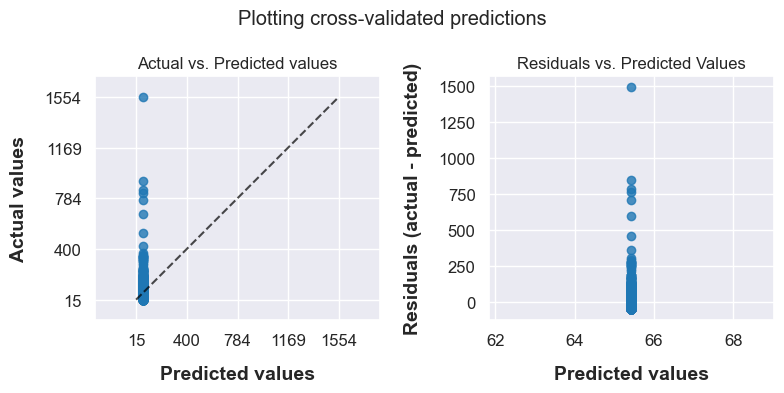

In [81]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    df_mlp_v4['DELAYED_TIME'],
    y_pred=df_mlp_v4['PRED_DELAY_TIME'],
    kind="actual_vs_predicted",
    subsample=1000,
    ax=axs[0],
    random_state=0,
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    df_mlp_v4['DELAYED_TIME'],
    y_pred=df_mlp_v4['PRED_DELAY_TIME'],
    kind="residual_vs_predicted",
    subsample=1000,
    ax=axs[1],
    random_state=0,
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show()

Classification

In [82]:
df.head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6
0,715,186.0,1065.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1280,235.0,1399.0,0.0,0.0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,594,118.0,680.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,969,260.0,1589.0,0.0,24.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1120,181.0,985.0,0.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [139]:
# Create random subset for quicker testing and debugging of code
df_subset = df.sample(100000)

In [140]:
for index, row in df_subset.iterrows():
    if row['DELAYED'] > 0:
        df_subset.at[index, 'OUTCOME'] = 1
    elif row['CANCELLED'] > 0:
        df_subset.at[index, 'OUTCOME'] = 1
    else:
        df_subset.at[index, 'OUTCOME'] = 0

In [132]:
df_subset[df_subset['OUTCOME'] == 'Bad'].head()

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,CANCELLED,DELAYED_TIME,DELAYED,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,...,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,OUTCOME
581016,914,94.0,370.0,0.0,37.0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,Bad
22644,950,190.0,1199.0,0.0,94.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Bad
1996984,461,146.0,853.0,0.0,73.0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,Bad
1921124,905,104.0,584.0,0.0,17.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Bad
1088853,765,308.0,2434.0,0.0,15.0,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,Bad


In [141]:
# drop the old columns
df_subset =  df_subset.drop(['DELAYED', 'CANCELLED', 'DELAYED_TIME'], axis=1)

In [179]:
# Time for the model
X = df_subset[feature_vars]
y = df_subset['OUTCOME']

# Split data into training and testing sets
(X_train_full, X_test, 
 y_train_full, y_test) = train_test_split(X, y, test_size=0.2,
                                          random_state=random_state)

# Split training data into training and validation subsets
(X_train, X_valid, 
 y_train, y_valid) = train_test_split(X_train_full, y_train_full,
                                      test_size=0.2,
                                      random_state=random_state)

In [183]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train.shape[1:]))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.add(keras.layers.Flatten())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 187)               0         
                                                                 
 dense (Dense)               (None, 100)               18800     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 2)                 62        
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 21,892
Trainable params: 21,892
Non-trainable params: 0
_________________________________________________________________


In [181]:
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [184]:

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=opt, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=2,
                    validation_data=(X_valid, y_valid),
                    epochs=5, verbose=1)

Epoch 1/5
32000/32000 [==============================] - 257s 8ms/step - loss: 0.9005 - accuracy: 0.2059 - val_loss: 0.8950 - val_accuracy: 0.2165
Epoch 2/5
32000/32000 [==============================] - 242s 8ms/step - loss: 0.9005 - accuracy: 0.2059 - val_loss: 0.8950 - val_accuracy: 0.2165
Epoch 3/5
32000/32000 [==============================] - 263s 8ms/step - loss: 0.9005 - accuracy: 0.2059 - val_loss: 0.8950 - val_accuracy: 0.2165
Epoch 4/5
32000/32000 [==============================] - 213s 7ms/step - loss: 0.9005 - accuracy: 0.2059 - val_loss: 0.8950 - val_accuracy: 0.2165
Epoch 5/5
32000/32000 [==============================] - 236s 7ms/step - loss: 0.9005 - accuracy: 0.2059 - val_loss: 0.8950 - val_accuracy: 0.2165


In [186]:
y_pred = model.predict(X_test)

625/625 [==============================] - 13s 9ms/step


In [187]:
y_pred

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [188]:
bce = keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.89940447>

In [156]:
y_pred

array([[104.26277 ,  80.20836 ,  28.753647, ...,   0.      ,   0.      ,
         74.99869 ],
       [232.28122 , 174.67467 ,  82.68344 , ...,   0.      ,   0.      ,
        177.33688 ],
       [152.4565  , 114.3601  ,  49.74953 , ...,   0.      ,   0.      ,
        115.842316],
       ...,
       [133.84094 , 100.11245 ,  47.69868 , ...,   0.      ,   0.      ,
        101.73121 ],
       [162.363   ,  55.782925,  79.45572 , ...,   0.      ,   0.      ,
         52.4607  ],
       [135.3573  ,  46.849617,  65.370575, ...,   0.      ,   0.      ,
         45.679012]], dtype=float32)

In [194]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [190]:
df_classify.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [166]:
y_test[0]

array([0., 1.], dtype=float32)

score = 

In [100]:
# Create model
tf.keras.backend.clear_session()
# Note we always have to clear session so it knows we are starting over rather than fine tuning

model = keras.models.Sequential([
    keras.layers.Dense(
        25, activation='relu',
        input_shape=X_train.shape[1:]
    ),
    keras.layers.Dense(1)
])

In [101]:
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

In [103]:
X_train

,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,AIRLINE_CODE_9E,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_F9,AIRLINE_CODE_G4,...,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_0,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6
1887790,505,125.0,759.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
673260,1232,169.0,1124.0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
712771,510,135.0,764.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
96248,1015,113.0,516.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1766093,1071,86.0,335.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914996,675,147.0,1014.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1088776,1059,136.0,589.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
369719,580,537.0,3904.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
957300,540,144.0,862.0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [91]:
# Load fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist

((X_train_full, y_train_full),
    (X_test, y_test)) = fashion_mnist.load_data() 

X_valid = X_train_full[:5000] / 255.0
X_train = X_train_full[5000:] / 255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]
X_test = X_test / 255.0 

class_names = [
    'T-Shirt or Top', 'Trouser', 'Pullover', 
    'Dress', 'Coat', 'Sandal', 'Shirt', 
    'Sneaker', 'Bag', 'Ankle Boot'
]

In [92]:
fashion_mnist.head()

AttributeError: module 'keras.api._v2.keras.datasets.fashion_mnist' has no attribute 'head'

In [ ]:
# Show raw data
X_train[0][0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00392157,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

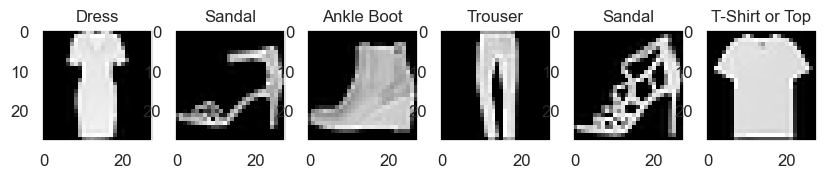

In [ ]:
# Output random training instances as images
fig, axs = plt.subplots(1, 6, figsize=(10, 4))
locs = np.random.randint(0, 5000, 6)
for i, ax in enumerate(axs):
    ax.imshow(X_train[locs[i]], cmap='gray')
    ax.set_title(class_names[y_train[locs[i]]])
    ax.grid(False)

plt.show()

In [ ]:
X_train[0].shape

(28, 28)

In [ ]:
28*28

784

In [ ]:
len(class_names)

10

In [116]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train.shape[1:]))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 187)               0         
                                                                 
 dense (Dense)               (None, 100)               18800     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 21,861
Trainable params: 21,861
Non-trainable params: 0
_________________________________________________________________


In [112]:
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

In [119]:
y_train = tf.one_hot(y_train, depth=2)

In [120]:
y_valid = tf.one_hot(y_valid, depth=2)
y_test = tf.one_hot(y_test, depth=2)

In [121]:
# Fit the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=opt, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32,
                    validation_data=(X_valid, y_valid),
                    epochs=30, verbose=1)

"""model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=1)"""


Epoch 1/30


ValueError: in user code:

    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((32, 1) vs (32, 2, 2, 2)).


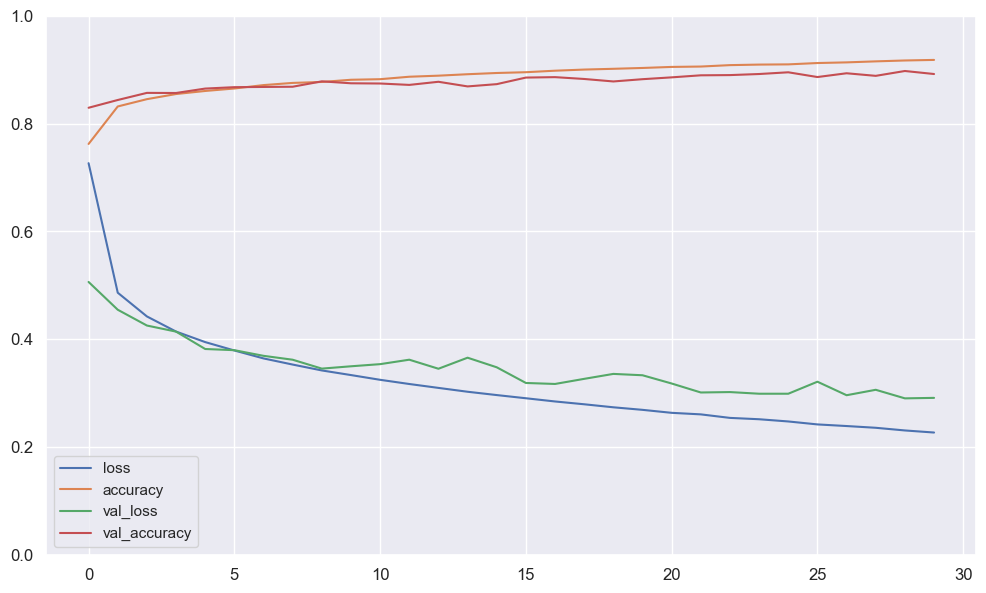

In [ ]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Evaluate on the test data
model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.3209 - accuracy: 0.8849


[0.3209136128425598, 0.8848999738693237]

In [ ]:
# Calculate a confusion matrix
print(class_names)

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
cm

['T-Shirt or Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
313/313 [==============================] - 3s 9ms/step


array([[886,   4,   8,  18,   3,   1,  73,   0,   7,   0],
       [  3, 979,   0,  13,   3,   0,   1,   0,   1,   0],
       [ 20,   1, 777,  14, 103,   1,  83,   1,   0,   0],
       [ 32,  18,  15, 884,  26,   0,  21,   0,   4,   0],
       [  0,   1,  68,  36, 827,   0,  66,   0,   2,   0],
       [  0,   0,   0,   1,   0, 943,   0,  36,   2,  18],
       [156,   2,  64,  26,  68,   0, 678,   0,   6,   0],
       [  0,   0,   0,   0,   0,  14,   0, 961,   1,  24],
       [ 12,   1,   6,   5,   5,   1,   6,   5, 959,   0],
       [  0,   0,   0,   0,   0,   8,   1,  36,   0, 955]])

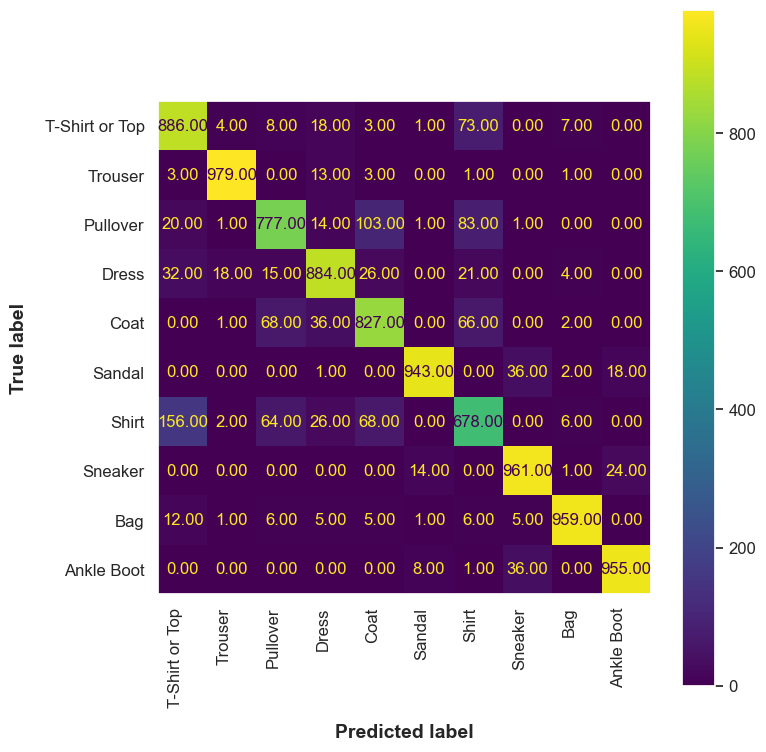

In [ ]:
# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

cmdisplay = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmdisplay.plot(values_format='.2f', ax=ax)

plt.grid(visible=None)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Get predictions. Note that the predict function returns class probabilities
y_prob = model.predict(X_test)
y_prob[:5]

313/313 [==============================] - 1s 4ms/step


array([[6.5602767e-06, 3.9914826e-06, 3.9125189e-06, 1.9235285e-06,
        6.1027677e-06, 1.9364837e-03, 1.8964938e-06, 5.5690529e-03,
        4.0630679e-04, 9.9206370e-01],
       [7.2439572e-05, 5.2913300e-08, 9.9234563e-01, 1.2295385e-08,
        7.2595393e-03, 1.6989384e-11, 3.2218816e-04, 3.9515974e-11,
        8.6986356e-09, 2.9692598e-12],
       [8.3795055e-07, 9.9999905e-01, 1.8563091e-08, 6.5713529e-08,
        1.6997223e-08, 5.1479545e-13, 5.7436900e-10, 5.1156324e-10,
        3.4856848e-10, 7.9534561e-13],
       [3.3732745e-06, 9.9998379e-01, 4.8171523e-07, 1.1940050e-05,
        2.3522979e-07, 7.5958412e-10, 1.0510530e-07, 7.2810288e-08,
        4.1833007e-10, 6.0687333e-10],
       [2.0053935e-01, 8.1144608e-05, 1.6423363e-02, 1.6382191e-03,
        1.4522333e-02, 8.8475517e-06, 7.6653683e-01, 9.7730958e-07,
        1.9684124e-04, 5.2152162e-05]], dtype=float32)

In [ ]:
# Get the model's predictions
y_pred = np.argmax(y_prob, axis=1)
y_pred[:5]

array([9, 2, 1, 1, 6])

In [ ]:
# Get the probabilities associated with the model's predictions
y_maxprob = np.max(y_prob, axis=1)
y_maxprob[:5]

array([0.9920637 , 0.99234563, 0.99999905, 0.9999838 , 0.76653683],
      dtype=float32)

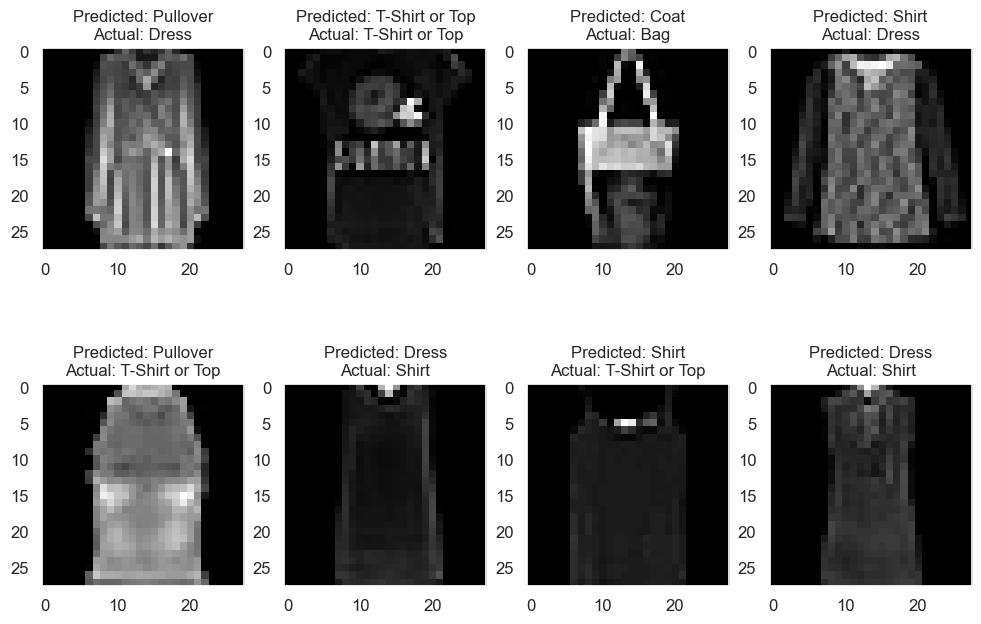

In [ ]:
# Show the least confident predictions
fig, ax = plt.subplots(2, 4, figsize=(12, 8))
locs = y_maxprob.argsort()[:10]
for i, a in enumerate(ax.reshape(-1)):
    a.imshow(X_test[locs[i]], cmap='gray')
    a.grid(False)
    a.set_title(f'Predicted: {class_names[y_pred[locs[i]]]}\n'
                f'Actual: {class_names[y_test[locs[i]]]}')

plt.show()

### Exercise

How much can you improve the model by adjusting the structure (e.g., number of layers) or hyperparameters?

Problem Set 4
1A:

In [ ]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(20, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 40,480
Trainable params: 40,480
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 13s 6ms/step - loss: 0.8297 - accuracy: 0.7154 - val_loss: 0.6100 - val_accuracy: 0.7762
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5384 - accuracy: 0.8121 - val_loss: 0.4841 - val_accuracy: 0.8322
Epoch 3/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4827 - accuracy: 0.8317 - val_loss: 0.4852 - val_accuracy: 0.8306
Epoch 4/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4518 - accuracy: 0.8423 - val_loss: 0.4322 - val_accuracy: 0.8484
Epoch 5/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4314 - accuracy: 0.8480 - val_loss: 0.4278 - val_accuracy: 0.8492
Epoch 6/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4126 - accuracy: 0.8552 - val_loss: 0.3981 - val_accuracy: 0.8630
Epoch 7/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4011 - accuracy: 0.8596 - val_loss: 0.3990 - val_accuracy

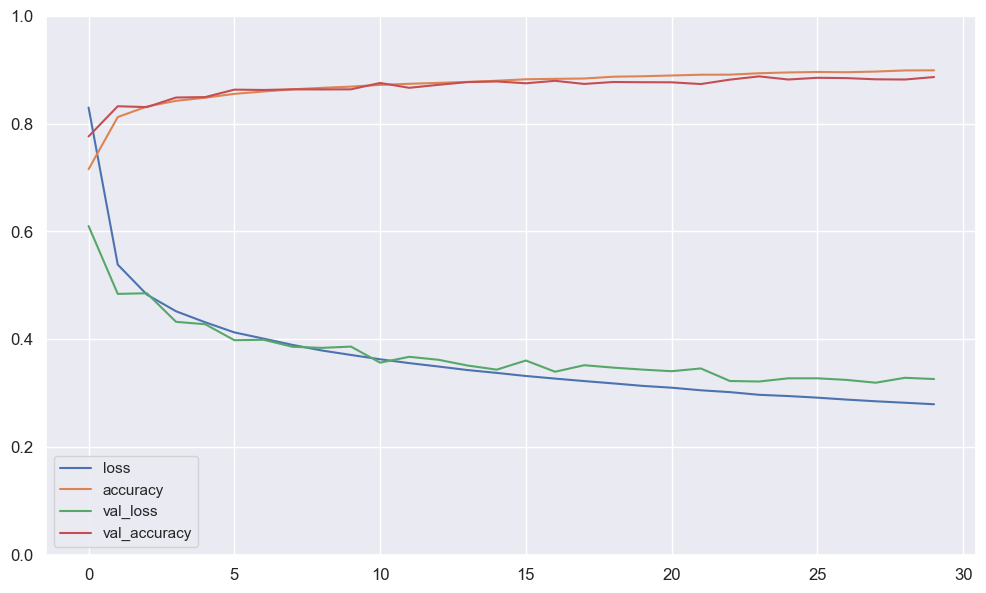

In [ ]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Original model:
![alt text](image-1.png)

The original model is getting slightly higher accuracy / less loss in fewer epochs than then modified onewith less neurons in the hidden layers. After 30 epochs, the accuracy / loss is also a bit better (OG at 30: loss: 0.2269 - accuracy: 0.9182. Modification A: loss: 0.2793 - accuracy: 0.8988)

So the original model (more neurons) had better validation performance

In [ ]:
# Evaluate on the test data
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.3615 - accuracy: 0.8690


[0.36145105957984924, 0.8690000176429749]

Generalization was worse for the modification with less neurons in the hidden layer based on how it performed with the test data (loss: 0.3615 - accuracy: 0.8690, original test performance was loss: 0.3209 - accuracy: 0.8849)

1B:

In [ ]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 271,160
Trainable params: 271,160
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 22s 11ms/step - loss: 0.7671 - accuracy: 0.7462 - val_loss: 0.4904 - val_accuracy: 0.8394
Epoch 2/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4876 - accuracy: 0.8281 - val_loss: 0.4887 - val_accuracy: 0.8176
Epoch 3/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4365 - accuracy: 0.8456 - val_loss: 0.4014 - val_accuracy: 0.8640
Epoch 4/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4061 - accuracy: 0.8563 - val_loss: 0.4068 - val_accuracy: 0.8570
Epoch 5/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3844 - accuracy: 0.8631 - val_loss: 0.3822 - val_accuracy: 0.8652
Epoch 6/30
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3664 - accuracy: 0.8688 - val_loss: 0.3733 - val_accuracy: 0.8678
Epoch 7/30
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3527 - accuracy: 0.8736 - val_loss: 0.3517 - val

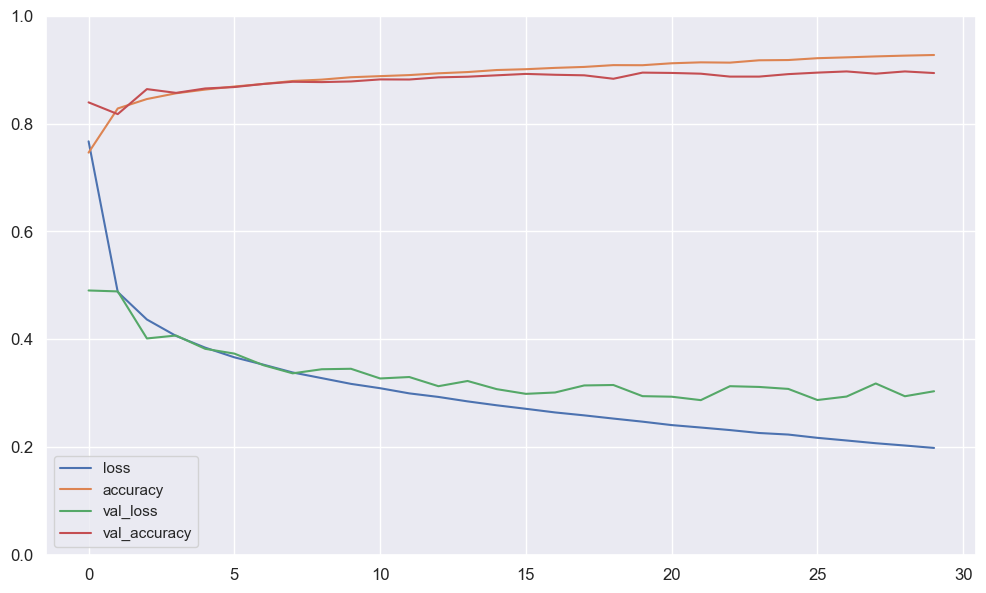

In [ ]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

The epoch training for modification took over 6 minutes compared to the about 4minutes and 30 seconds it took for the modification A model, so adding the additional layer with even more neurons takes more resources to train, even when using same number of epochs.

As for how the validation performance was after the 30 epochs:
OG at 30: loss: 0.2269 - accuracy: 0.9182
Mod B: loss: 0.1983 - accuracy: 0.9273

So while it takes more time/ resources, it does have a better validation performance. It also is minimizing loss faster, comparing the graphs the modification B has loss decreasing a bit faster than the original 


In [ ]:
# Evaluate on the test data
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 6ms/step - loss: 0.3466 - accuracy: 0.8797


[0.34664398431777954, 0.8797000050544739]

OG generalization performance: loss: 0.3209 - accuracy: 0.8849
Mod B: loss: 0.3466 - accuracy: 0.8797

So modification B was actually worse at generalization than the original model, likely due to overtraining on the test data.

Problem 2:

In [ ]:
# Load CIFAR-10 data
((X_train_full, y_train_full),
 (X_test, y_test)) = keras.datasets.cifar10.load_data()

X_valid = X_train_full[:5000] / 255.0
X_train = X_train_full[5000:] / 255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]
X_test = X_test / 255.0

image_dims = (32, 32, 3)

class_names = [
    'airplane', 'automobile', 'bird',
    'cat', 'deer', 'dog', 'frog',
    'horse', 'ship', 'truck'
]

In [ ]:
# Define network
tf.keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', 
                        input_shape=image_dims),
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'), 
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation='elu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation='elu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(len(class_names), activation='softmax')
]) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         2

In [ ]:
# Fit the model
# This model takes a while to fit
X_train = X_train.reshape(*X_train.shape, 1)
X_valid = X_valid.reshape(*X_valid.shape, 1)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=2, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1407/1407 [==============================] - 647s 458ms/step - loss: 1.8771 - accuracy: 0.2964 - val_loss: 1.5616 - val_accuracy: 0.4288
Epoch 2/2
1407/1407 [==============================] - 518s 368ms/step - loss: 1.5024 - accuracy: 0.4499 - val_loss: 1.2914 - val_accuracy: 0.5378


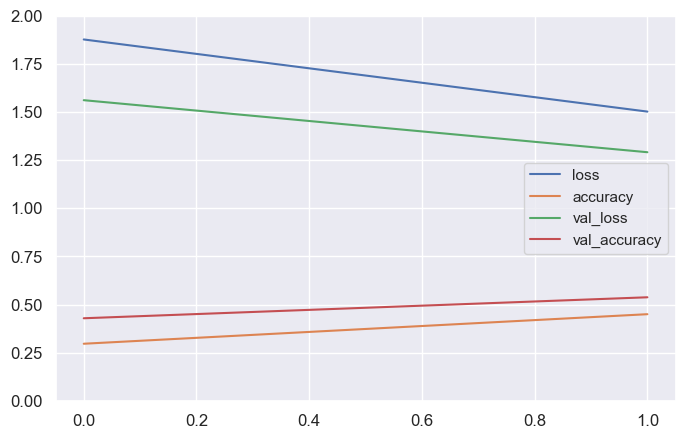

In [ ]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [ ]:
# Evaluate on the test data
# Note that this model outperforms the dense model we examined previously
X_test = X_test.reshape(*X_test.shape, 1)
model.evaluate(X_test, y_test)

313/313 [==============================] - 30s 97ms/step - loss: 1.3253 - accuracy: 0.5186


[1.3253153562545776, 0.5185999870300293]

We used a convolutional neural network to classify images from the CIFAR-10 dataset. I used 2 epochs as increasing epochs would be a time constraint and mentioned in class 2-3 should be fine. I kept learning rate the same as the previous notebook. My model's performance isn't great, at .5186 for generaliztation. It is still better than random guesses (my initial thought was being so close to .5 was same as random guessing, however there are 10 labels so a random guess would have a .1 expected accuracy)

I am going to try to use 3 epochs instead and increase the learning rate to .1 to see if there is better performance.

In [ ]:
# Define network
tf.keras.backend.clear_session()

model = keras.models.Sequential([ 
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', 
                        input_shape=image_dims),
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'), 
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(), 
    keras.layers.Dense(128, activation='elu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation='elu'), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(len(class_names), activation='softmax')
]) 

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/3
1407/1407 [==============================] - 681s 474ms/step - loss: 1.9223 - accuracy: 0.2763 - val_loss: 1.5071 - val_accuracy: 0.4470
Epoch 2/3
1407/1407 [==============================] - 611s 434ms/step - loss: 1.5108 - accuracy: 0.4476 - val_loss: 1.3580 - val_accuracy: 0.5106
Epoch 3/3
1407/1407 [==============================] - 720s 511ms/step - loss: 1.3607 - accuracy: 0.5108 - val_loss: 1.2206 - val_accuracy: 0.5576


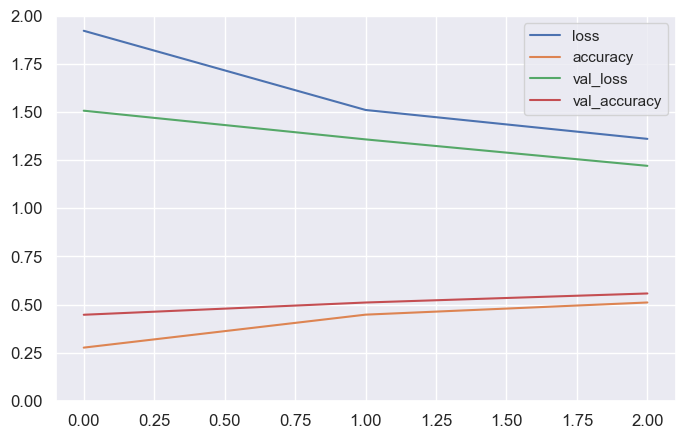

In [ ]:
# Chart the learning process
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [ ]:
# Evaluate on the test data
# Note that this model outperforms the dense model we examined previously
X_test = X_test.reshape(*X_test.shape, 1)
model.evaluate(X_test, y_test)

2024-03-26 22:01:31.478120: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at conv_ops_fused_impl.h:720 : INVALID_ARGUMENT: input must be 4-dimensional[32,32,32,3,1,1,1]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/42/lwn0p9jn7tx0bxw3zzznklvr0000gn/T/ipykernel_34281/3458497974.py", line 4, in <module>
      model.evaluate(X_test, y_test)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 314, in call
      return self.activation(outputs)
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/Users/kyle/miniconda3/envs/ds/lib/python3.10/site-packages/keras/backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d/Relu'
input must be 4-dimensional[32,32,32,3,1,1,1]
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_test_function_1342985]

I think I messed up by not resetting the variables before running the new model, as they were reshaped previously. My thinking was I didn't want to chang the training / test split so that it wouldn't affect the differences in model performance. Although this was probably not necessary since we set random state in the first cell. I would try again if it didn't take 33 minutes, but based on validation this model was not much more accurate.

3:
I am a fan of Amazon's algorithm for predicting and reccomending products you may like, as it makes it easy to find products without searching and they are normally pretty good reccommendations.

Maybe some classification (similarity / type of product) and what type of products you buy. And then regression or decision trees (or likely neural networks due to their scale) for predicting likelihood to buy specific product

The are constantly collecting data on demographics / geographic data / and purchasing data for all their users, providing them with an extremely large amount of data to allow for training 

I think for some products that have closer ties to each other / higher number of purchases there will be better performance (for example I recently bought a new desk and was recommended wire organizer and monitor stand that were related purchases recommended to me and I did end up going with one of them) where as a user who does not have much purchase history and buys niche and unrelated products may get poor predictions. 
Overall, their model is probably pretty accurate with all their data, but they also likely tailor it some some that it weights certain products higher (is it an Amazon Prime product? Is it a product that they make more money from?) so a super high accuracy is not super needed 

I think it is pretty accurate for me, especially as my purchase history grows. There are times where I have bought something as a gift for someone, and I later get similar items recommended, but this is not a fault of the model. And while I do notice Prime eligible products seem to be higher recommended, this is good for me since I already have Prime and enjoy the faster shipping. 